In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts
import scipy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
%matplotlib widget

### This Notebook explores improvements to solving the quadratic problem

Some challenges:
1. If we search over all features, the problem is much to large to handle
2. Occasionally, the solver will not converge. Terminating with 'Singular or KKT matrix error' meaning the problem is not convex

Some potential solutions:
1. Reducing computational size
    - Make the matrices sparse, perhaps we will still get a good enough answer s.t. when we reduce the feature bank we end up with the same features. We can make P sparse, or try to make feature bank and cov (or invcov) sparse. 
    - Randomly solving for elements of the larger problem
    - Leveraging the low rank properties of our P matrix
    - A better way to reduce the 'size' of A is to take the first k elements from a singular value decomposition


2. Sovler not converging
    - Rescale the size of the problem 
        - scaling will also allow for finer precision
    - Generally a few large values in the constraints will cause issues:
        - norm(A) < 1 helps where A is constraint matrix
        - Redundant constraints box-type constraints x[k] <= u for large u
        - Big-M type penalty terms
        - Ax=b where a few b[k] are very large,  or a few A[k,j] are very large


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-0.7675283643313486, 9.594104554141857)

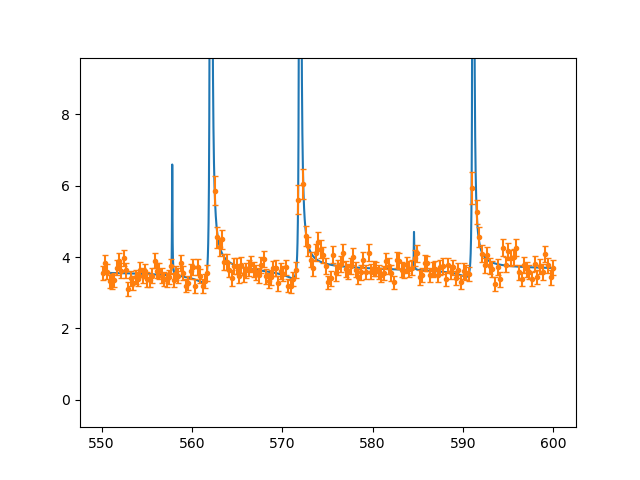

In [6]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.6,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

from ATARI.utils.datacontainer import DataContainer
from ATARI.theory.experimental import trans_2_xs

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

max_xs, _ = trans_2_xs(threshold_0T, dc.n)

figure()
plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
ylim([-max_xs*.1, max_xs*1.25])

In [7]:
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e0)
Gtot_features = np.round(np.array(resonance_ladder.Gt),1)*1e-3
# Elam_features = np.round(np.array(resonance_ladder.E),1)
# Elam_features = Elam_features[0:int(len(Elam_features)/2)]
# Gtot_features = Gtot_features[::2]

# get resonance feature matrix
Resonance_Matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(dc.pw_exp.E, dc.particle_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]
print(nfeatures)
# print(Gtot_features)

2505


In [8]:
# scale = 1/np.diag(Resonance_Matrix @ Resonance_Matrix.T)
# scale = np.diag(scale)



P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.E), np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), 
                                                potential_scattering.flatten(), max_xs, Resonance_Matrix, feature_pairs, Ta_pair) 
# exp_E, exp_xs, cov_xs, potential_scattering, max_xs, feature_matrix, feature_pairs, particle_pair

unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                                solver="cvxopt",
                                                                # solver="scs",
                                                                verbose=True,
                                                                abstol=1e-12,
                                                                reltol=1e-12,
                                                                feastol= 1e-8,
                                                                maxiters = 200)



     pcost       dcost       gap    pres   dres
 0: -2.0969e+02 -3.9316e+03  2e+04  2e+00  3e-01
 1: -2.0969e+02 -2.0113e+03  3e+03  2e-01  3e-02
 2: -2.0969e+02 -1.0007e+03  1e+03  8e-02  1e-02
 3: -2.0969e+02 -3.6324e+02  3e+02  1e-02  2e-03
 4: -2.0969e+02 -2.9880e+02  1e+02  6e-03  9e-04
 5: -2.0969e+02 -2.5319e+02  7e+01  2e-03  3e-04
 6: -2.0969e+02 -2.1983e+02  1e+01  4e-04  6e-05
 7: -2.0969e+02 -2.1260e+02  4e+00  1e-04  2e-05
 8: -2.0969e+02 -2.1240e+02  4e+00  1e-04  2e-05
 9: -2.0968e+02 -2.1210e+02  4e+00  1e-04  1e-05
10: -2.0965e+02 -2.1134e+02  4e+00  8e-05  1e-05
11: -2.0954e+02 -2.1014e+02  4e+00  7e-05  1e-05
12: -2.0913e+02 -2.0780e+02  4e+00  6e-05  9e-06
13: -2.0846e+02 -2.0543e+02  4e+00  5e-05  8e-06
14: -2.0803e+02 -2.0432e+02  5e+00  5e-05  7e-06
15: -2.0646e+02 -2.0148e+02  5e+00  4e-05  6e-06
16: -2.0454e+02 -1.9906e+02  5e+00  3e-05  5e-06
17: -2.0337e+02 -1.9799e+02  5e+00  3e-05  4e-06
18: -2.0144e+02 -1.9662e+02  5e+00  2e-05  3e-06
19: -1.9946e+02 -1.95

In [9]:
index_0T

array([ 45,  46,  82, 150])

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


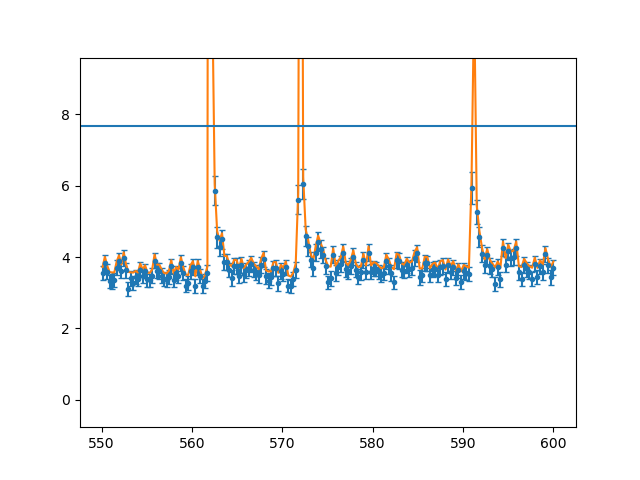

In [10]:
figure()
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten())
# plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w_sparse+potential_scattering.flatten())
ylim([-max_xs*.1, max_xs*1.25])
axhline(max_xs)

### Reduce size using lp solve first

In [24]:
# P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), max_xs, Resonance_Matrix)
# lp_unconstrained_w = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)
# print(np.count_nonzero(lp_unconstrained_w.x>0))

# reduced_feature_matrix, reduced_feature_pairs = fn.get_reduced_feature_matrix(Resonance_Matrix, lp_unconstrained_w.x, 1e-1, feature_pairs)

# P_reduced, q_reduced, G_reduced, h_reduced, lb_reduced, ub_reduced, index_0T_reduced = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), 
#                                                                                                             max_xs, reduced_feature_matrix)

# unconstrained_solw_reduced = solve_qp(P_reduced, q_reduced, G=G_reduced, h=h_reduced, A=None, b=None, lb=lb_reduced, ub=ub_reduced, 
#                                                                                                 solver="cvxopt",
#                                                                                                 verbose=True,
#                                                                                                 abstol=1e-12,
#                                                                                                 reltol=1e-12,
#                                                                                                 feastol= 1e-8,
#                                                                                                 maxiters = 100)
# unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
#                                                                 solver="cvxopt",
#                                                                 # solver="scs",
#                                                                 verbose=True,
#                                                                 abstol=1e-10,
#                                                                 reltol=1e-10,
#                                                                 feastol= 1e-7,
#                                                                 maxiters = 200)

# figure()
# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
# # plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
# # plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten())
# plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_solw_reduced+potential_scattering.flatten())
# ylim([-max_xs*.1, max_xs*1.25])

### Approximate as Sparse Matrices

In [22]:
### consider using a sparse matrix solver and just forcing elements of P to zero below some threshold
# can also make resonance matrix and datacov sparse (can make datacov or invdatacov sparse)


# figure()
# plot(np.array(Resonance_Matrix)[100,:])
# imshow(np.log10(np.array(dc.CovXS)))
# plot(np.diag(np.array(dc.CovXS)))




def get_qp_inputs_sparse(exp_E, exp_xs, cov_xs, potential_scattering, max_xs, feature_matrix, feature_pairs, particle_pair):
    nfeatures = np.shape(feature_matrix)[1]
    
    # remove nan values in xs and cov for solver
    b, cov, pscat, A, index_0T = fn.remove_nan_values(exp_xs, cov_xs, potential_scattering, feature_matrix)
    b = b-pscat
    b_sparse = scipy.sparse.csc_matrix(b)

    # get bounds and constraints
    lb, ub = fn.get_bound_arrays(nfeatures, 0, 1)
    G, h = fn.get_0Trans_constraint(exp_E, index_0T, max_xs, particle_pair, feature_pairs)
    G = scipy.sparse.csc_matrix(G)
    # h = scipy.sparse.csc_matrix(h)

    # make A and cov sparse
    A_sparse = A.copy()
    A_sparse[abs(A_sparse)<15] = 0
    A_sparse = scipy.sparse.csc_matrix(A_sparse)
    cov_sparse = np.array(cov).copy()
    cov_sparse[abs(cov_sparse)<0.02] = 0 
    cov_sparse = scipy.sparse.csc_matrix(cov_sparse)

    # Cast into quadratic program 
    P = A_sparse.T @ scipy.sparse.linalg.inv(cov_sparse) @ A_sparse
    # q = - A.T @ inv(cov) @ b
    q = - A_sparse.T @ scipy.sparse.linalg.inv(cov_sparse) @ b

    return P, q, G, h, lb, ub, index_0T


P_sparse, q_sparse, G_sparse, h_sparse, lb_sparse, ub_sparse, index_0T_sparse = get_qp_inputs_sparse(np.array(dc.pw_exp.E), np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), 
                                                                                                     potential_scattering.flatten(), max_xs, Resonance_Matrix,feature_pairs, Ta_pair)


# # test = P
# # test[abs(P)<30000] = 0


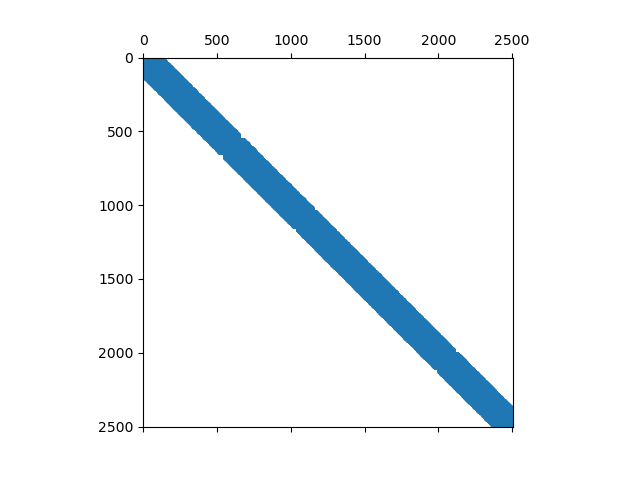

In [23]:

figure()
# bins = hist(np.log10(P[1000,:]), bins=25)
# plot(test[2000,:])
# plot(test[:,3000])
spy(P_sparse)
# spy(P)


In [24]:
P.data.nbytes

50200200

In [25]:
# np.count_nonzero(P_sparse.)
P_sparse.data.nbytes


1354856

In [27]:
unconstrained_w_sparse = solve_qp(P_sparse, q_sparse, G=G_sparse, h=h_sparse, A=None, b=None, lb=lb_sparse, ub=ub_sparse, 
                                                                # solver="cvxopt",
                                                                solver="osqp")#,
                                                                # verbose=True,
                                                                # abstol=1e-11,
                                                                # reltol=1e-11,
                                                                # feastol= 1e-7,
                                                                # maxiters = 200)

print(np.count_nonzero(unconstrained_w_sparse>1e-10))

811


(-0.7675283643313486, 9.594104554141857)

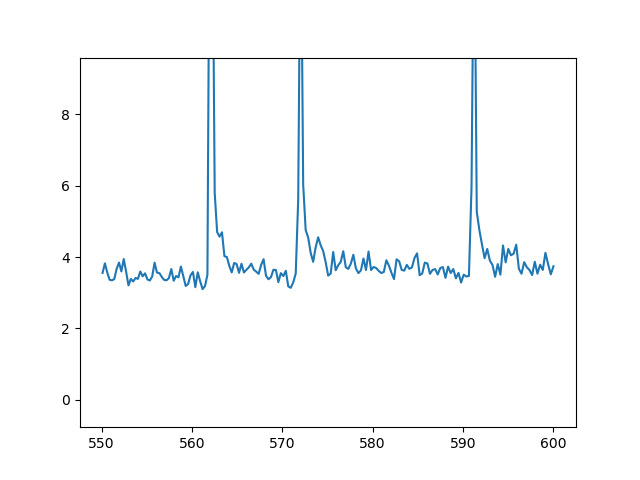

In [28]:
figure()
# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
# plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten())
plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w_sparse+potential_scattering.flatten())
ylim([-max_xs*.1, max_xs*1.25])

### Use singular value decomposition to reduce the matrix size initially

In [6]:
### Sigular value decomp
# u, s, vh = np.linalg.svd(Resonance_Matrix)
# # np.shape(s)
# val = 10
# u10 = u[:, 0:val]
# s10 = np.diag(s[0:val])
# vh10 = vh[0:val,:]
# testa = u10 @ s10 @ vh10

# import numpy as np

# # # Define the original quadratic matrix
# # Q = np.array([[4, -2, 1],
# #               [-2, 5, -3],
# #               [1, -3, 6]])
# # # Perform Singular Value Decomposition (SVD)
# # U, S, Vt = np.linalg.svd(Q)
# # # Define the desired rank of the approximation
# # k = 2
# # # Truncate the singular values and matrices
# # Uk = U[:, :k]
# # Sk = np.diag(S[:k])
# # Vtk = Vt[:k, :]
# # # Construct the low-rank approximation of the quadratic matrix
# # Qk = Uk @ Sk @ Vtk

# P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), max_xs, testa)

In [8]:
# unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
#                                                                 solver="cvxopt",
#                                                                 # solver="scs",
#                                                                 verbose=True,
#                                                                 abstol=1e-10,
#                                                                 reltol=1e-10,
#                                                                 feastol= 1e-7,
#                                                                 maxiters = 200)
# lp_unconstrained_w = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)

In [12]:
# np.argwhere(lp_unconstrained_w.x>0.5).flatten()

array([ 4294,  4295,  4296, ..., 19035, 19036, 19037])